# A/B TEST
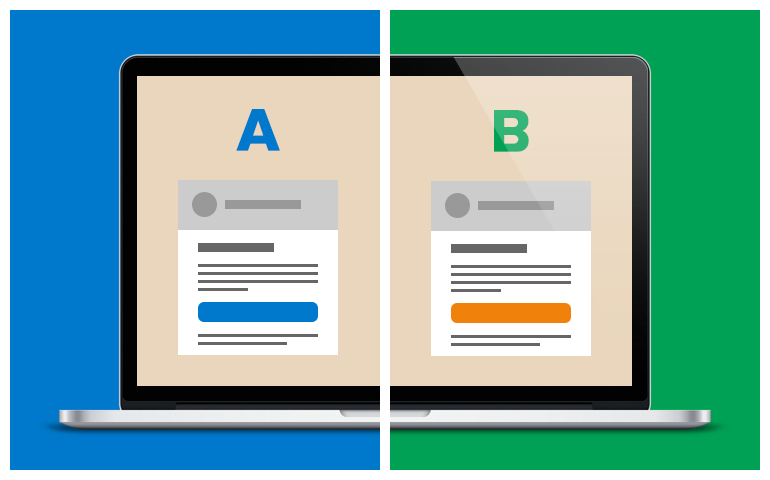

A/B testing is a user experience research technique. They are tests that allow us to decide which would be better between any two features or strategies. With A/B tests, many features such as being a member of a site, clicking, clicking on advertisements, going to a sale can be tested. In the dataset here, we will observe whether a change made in the web interface of a market increases the number of clicks. First, let's import the necessary libraries and read the data. Then let's see what the data looks like...

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, pearsonr, spearmanr, kendalltau, \
    f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("grocerywebsiteabtestdata.csv")
df.head()

,RecordID,IP Address,LoggedInFlag,ServerID,VisitPageFlag
0,1,39.13.114.2,1,2,0
1,2,13.3.25.8,1,1,0
2,3,247.8.211.8,1,1,0
3,4,124.8.220.3,0,3,0
4,5,60.10.192.7,0,2,0


In [3]:
df.shape

(184588, 5)

An IP Address may have visited the page more than once. So that this doesn't affect the results, I reduce the Visit value to 1 for users with multiple visits.

In [4]:
df = df.groupby(["IP Address", "LoggedInFlag", "ServerID"])["VisitPageFlag"].sum()

In [5]:
df = df.reset_index(name="VisitPageFlagSum")
df.head()

,IP Address,LoggedInFlag,ServerID,VisitPageFlagSum
0,0.0.108.2,0,1,0
1,0.0.109.6,1,1,0
2,0.0.111.8,0,3,0
3,0.0.160.9,1,2,0
4,0.0.163.1,0,2,0


In [6]:
df["VisitPageFlag"] = df["VisitPageFlagSum"].apply(lambda x: 1 if x != 0 else 0)
df.head()

,IP Address,LoggedInFlag,ServerID,VisitPageFlagSum,VisitPageFlag
0,0.0.108.2,0,1,0,0
1,0.0.109.6,1,1,0,0
2,0.0.111.8,0,3,0,0
3,0.0.160.9,1,2,0,0
4,0.0.163.1,0,2,0,0


Then I need to split the dataset into Test and Control groups. I will perform this operation with the help of ServerID. I set ServerID 1 as  Test group and ServerID 2 and 3 as Control group.

In [7]:
df['group'] = df['ServerID'].map({1:'Test', 2:'Control', 3:'Control'})
df.drop(['ServerID','VisitPageFlagSum'],axis=1, inplace=True)

In [8]:
df.head()

,IP Address,LoggedInFlag,VisitPageFlag,group
0,0.0.108.2,0,0,Test
1,0.0.109.6,1,0,Test
2,0.0.111.8,0,0,Control
3,0.0.160.9,1,0,Control
4,0.0.163.1,0,0,Control


In [9]:
df_control = df[df['group'] == 'Control'].copy()
df_control.reset_index(inplace=True, drop = True)

In [10]:
df_test = df[df['group'] == 'Test'].copy()
df_test.reset_index(inplace=True, drop = True)

In [11]:
df_control.head()

,IP Address,LoggedInFlag,VisitPageFlag,group
0,0.0.111.8,0,0,Control
1,0.0.160.9,1,0,Control
2,0.0.163.1,0,0,Control
3,0.0.178.9,1,0,Control
4,0.0.185.4,1,0,Control


In [12]:
df_test.head()

,IP Address,LoggedInFlag,VisitPageFlag,group
0,0.0.108.2,0,0,Test
1,0.0.109.6,1,0,Test
2,0.0.169.1,1,0,Test
3,0.0.181.9,0,1,Test
4,0.0.195.5,1,0,Test


Let's examine the descriptive statistics of the control group.

In [13]:
df_control.describe().T

,count,mean,std,min,25%,50%,75%,max
LoggedInFlag,66460.0,0.503912,0.499988,0.0,0.0,1.0,1.0,1.0
VisitPageFlag,66460.0,0.092251,0.289382,0.0,0.0,0.0,0.0,1.0


Now let's examine the descriptive statistics of the Test group.

In [14]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
LoggedInFlag,33303.0,0.503258,0.499997,0.0,0.0,1.0,1.0,1.0
VisitPageFlag,33303.0,0.115515,0.319647,0.0,0.0,0.0,0.0,1.0


In the control data set, let's calculate the ratio of those who enter the page we want, compared to all those who enter the site.

In [15]:
control_sum_visit = df_control['VisitPageFlag'].count()
print("Sum visit for control group: ", control_sum_visit)
control_visit_1 = df_control[df_control['VisitPageFlag'] ==1]['VisitPageFlag'].count()
print("Visit Page target = 1 : ", control_visit_1)

Sum visit for control group:  66460
Visit Page target = 1 :  6131


In [16]:
control_ratio_visit = control_visit_1/control_sum_visit
control_ratio_visit

0.09225097803189888

We calculate the same ratio within the Test group.

In [17]:
test_sum_visit = df_test['VisitPageFlag'].count()
print("Sum visit for test group: ", test_sum_visit)
test_visit_1 = df_test[df_test['VisitPageFlag'] ==1]['VisitPageFlag'].count()
print("Visit Page target = 1 : ", test_visit_1)

Sum visit for test group:  33303
Visit Page target = 1 :  3847


In [18]:
test_ratio_visit = test_visit_1/test_sum_visit
test_ratio_visit

0.11551511875806984

When we look directly at the click rates, we see that there is a difference between the two groups. It seems that the new feature applied to the test group is getting more clicks. But this result can be misleading. Therefore, we should seek an answer to the question of whether there is a statistically significant difference. Now we will run A/B testing.

For A/B testing to be applied, the data set must satisfy the Normality and Variance homogeneity assumptions. Then, it can be passed to the implementation of the hypothesis tests.
   1. If normality and variance homogeneity is provided, an independent two-sample t-test (parametric test) is applied.
   2. If normality and homogeneity of variance are not provided, the Mann-Whitney U test (non-parametric test) is performed.
How to check the assumption of normality?
In this, we will first determine the H0 and H1 hypotheses.

- H0 : The assumption of normality is provided.
- H1 : The assumption of normality is not provided.

Now let's check the assumption of normality.

# Normality Assumption

In [19]:
test_stat, pvalue = shapiro(df_control["VisitPageFlag"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 0.3266, p-value = 0.0000


In [20]:
test_stat, pvalue = shapiro(df_test["VisitPageFlag"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 0.3711, p-value = 0.0000


H0 is rejected because the p-value is <0.05. The assumption of normality was not provided.

Therefore, we will use the Mann-Whitney U test.

- H0 : There is no significant difference between the two groups in terms of click rate to the desired page.
- H1 : There is a difference.

# Mann-Whitney U Test

In [21]:
test_stat, pvalue = mannwhitneyu(df_control["VisitPageFlag"],
                                 df_test["VisitPageFlag"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 1080913226.5000, p-value = 0.0000


H0 is rejected because p-value<0.05. In other words, we can say statistically that there is a difference between the two groups.

In [23]:
group_count = df.groupby(['group', 'VisitPageFlag'])['group'].count().reset_index(name='Count')
groupped = pd.crosstab(group_count['group'], group_count['VisitPageFlag'], values=group_count['Count'], aggfunc=np.sum, margins=True)

In [24]:
100*groupped.div(groupped['All'], axis=0)

VisitPageFlag,0,1,All
group,,,
Control,90.774902,9.225098,100.0
Test,88.448488,11.551512,100.0
All,89.998296,10.001704,100.0


# Conclusion
While the rate of clicking on the link was 9.22% in the Control group, this rate increased to 11.55% in the Test group.
As a result of our tests, we can say that this rate increase is not accidental, but has been proven statistically.